In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ChiLit_Topic_Modeling

/content/drive/MyDrive/ChiLit_Topic_Modeling


In [3]:
import os

In [4]:
os.getcwd()

'/content/drive/MyDrive/ChiLit_Topic_Modeling'

In [5]:
!pip install bibtexparser
!pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=fdb063657caaf828cb78c57db68b499c5f550061a13e707637cec0e6fc0e9749
  Stored in directory: /root/.cache/pip/wheels/16/fb/76/306387739cf9d53b1c39b0c8aadbbb17dc05f256756d8fd915
Successfully built bibtexparser


In [6]:
import bibtexparser
import requests
import pandas as pd
import numpy as np
import json
import re

### Metadata

In [10]:
url = 'https://raw.githubusercontent.com/mahlberg-lab/corpora/refs/heads/master/corpora.bib'
filename = 'corpora.bib'
response = requests.get(url)
if response.status_code == 200:
  bibtex_str = response.content

In [12]:
library = bibtexparser.loads(bibtex_str)

In [13]:
library.entries[0]

{'keywords': '{ChiLit}',
 'date': '1900',
 'urldate': '2017-09-10',
 'author': 'Anstey, F.',
 'shorttitle': 'brass',
 'url': 'https://www.gutenberg.org/ebooks/30689',
 'title': 'The Brass Bottle',
 'ENTRYTYPE': 'book',
 'ID': 'anstey_brass_1900'}

In [14]:
df = pd.DataFrame(library.entries)

In [15]:
df.head()

,keywords,date,urldate,author,shorttitle,url,title,ENTRYTYPE,ID,editor,publisher,number,series,location
0,{ChiLit},1900,2017-09-10,"Anstey, F.",brass,https://www.gutenberg.org/ebooks/30689,The Brass Bottle,book,anstey_brass_1900,NaN,NaN,NaN,NaN,NaN
1,{ChiLit},1897,2017-09-10,"Crockett, S. R.",toadylion,https://www.gutenberg.org/ebooks/39340,The Surprising Adventures of Sir Toady Lion wi...,book,crockett_surprising_1897,NaN,NaN,NaN,NaN,NaN
2,{ChiLit},1910,2017-09-10,"Mare, W. De la",mulgars,https://www.gutenberg.org/ebooks/32620,The Three Mulla-mulgars,book,mare_three_1910,NaN,NaN,NaN,NaN,NaN
3,{ChiLit},1869,2017-09-10,"Ewing, J. H. G.",overtheway,https://www.gutenberg.org/ebooks/17772,Mrs. Overtheway's Remembrances,book,ewing_mrs._1869,NaN,NaN,NaN,NaN,NaN
4,{ChiLit},1883,2017-09-10,"Ewing, J. H. G.",jackanapes,https://www.gutenberg.org/ebooks/20351,Jackanapes,book,ewing_jackanapes_1883,NaN,NaN,NaN,NaN,NaN


In [26]:
df_chilit = df[df['keywords'] == '{ChiLit}'][['author','title','date','shorttitle']]

In [27]:
len(df_chilit)

71

In [28]:
df_chilit.to_csv("ChiLit_metadata.csv", encoding="utf-8", index=False)

In [29]:
print(df_chilit['date'].min())
print(df_chilit['date'].max())

1826
1911


In [31]:
df_chilit['decade'] = [ int(np.floor(int(year)/10) * 10) for year in np.array(df_chilit["date"])]

<Axes: xlabel='decade'>

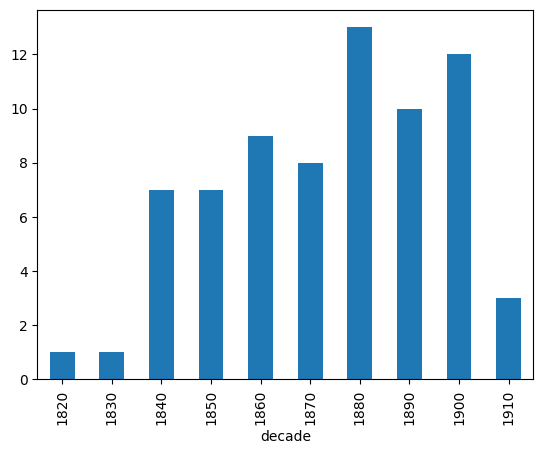

In [32]:
df_chilit.groupby(['decade'])['title'].count().plot(kind='bar')

### Split into chapters

In [19]:
def download_clic_json(url, output_filename):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise exception for HTTP errors

        # Parse JSON content
        data = response.json()

        # Save to a JSON file
        with open(output_filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)

        print(f"JSON data saved to '{output_filename}'.")

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Failed to parse JSON: {ve}")

In [17]:
df_chilit = pd.read_csv("ChiLit_metadata.csv", encoding = "utf-8")

In [26]:
for index, row in df_chilit.iterrows():
    book = row['shorttitle']
    url = f"https://clic.bham.ac.uk/api/text?corpora={book}&regions=chapter.title"
    output_file = f"{os.getcwd()}/data/chapters_metadata/{book}_chapters.json"
    download_clic_json(url, output_file)

JSON data saved to '/content/drive/MyDrive/ChiLit_Topic_Modeling/data/chapters_metadata/brass_chapters.json'.


In [27]:
for index, row in df_chilit.iterrows():

    book = row['shorttitle']
    json_file = f"{os.getcwd()}/data/chapters_metadata/{book}_chapters.json"

    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    chapter_start = [s[1] for s in data['data']]
    if len(chapter_start) == 0:
        print(book)
        chapter_start.append(0)
    chapter_start.append(len(data['content']))

    chapter_num = 1
    for start_char, end_char in zip(chapter_start, chapter_start[1:]):
        chapter_text = data['content'][start_char:end_char]
        chapter_file = f"./data/chapters/{book}_{chapter_num:03}.txt"
        with open(chapter_file, 'w', encoding='utf-8') as f:
            f.write(chapter_text)
        chapter_num +=1

overtheway
unlikely
rival
prince
squirrel
bunny
mice
rabbit
jemima
jungle
flopsy


In [7]:
from corpusanalyzer import CorpusAnalyzer
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus.reader import PlaintextCorpusReader

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
data_dir = './data/'
chilit = PlaintextCorpusReader(root = data_dir + "chapters", fileids = r'.+\.txt')
# Initialize analyzer
analyzer = CorpusAnalyzer(chilit)
# Perform analysis
individual_stats, corpus_summary, df = analyzer.analyze_corpus()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


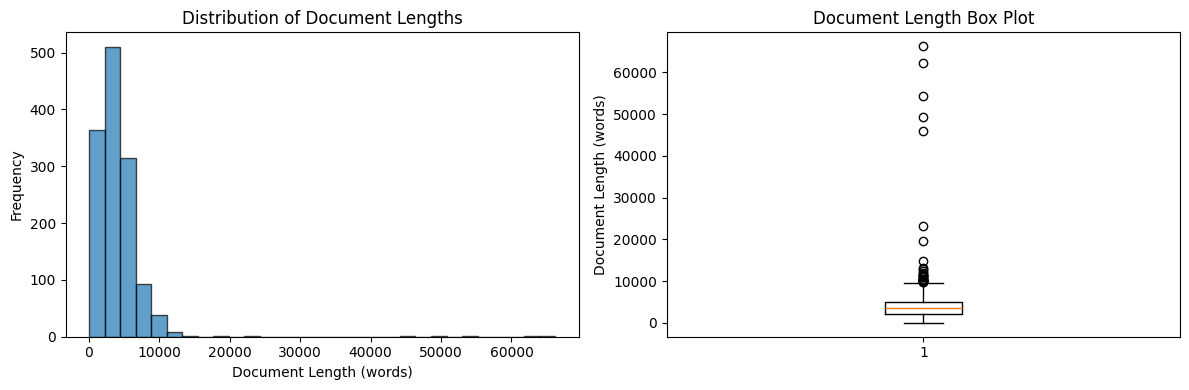

In [9]:
# Analysis of Document Lenghts
doc_lengths, stats = analyzer.analyze_document_lengths(individual_stats)
analyzer.plot_length_distribution(doc_lengths)